# Machine Learning Report

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

import warnings

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.debugging.set_log_device_placement(False)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15313678823060716339
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6590298194
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5727338978693092541
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


## Contents
- Loading the data
- Experimenting with the data
    - PCA
    - Regularisation
        - Using Preprocessing
        - Using MinMax Scaling
- Deep Learning Approach
- Classical Learning Approaches
    - Supervised Learning
        - K-Nearest Neighbours
        - Support Vector Machine
    - Unsupervised Learning
        - K-Means

## Loading the data

In [3]:
atlas_labels = pd.read_csv("ATLAS-labels.csv", header=None)
atlas_data = pd.read_csv("ATLAS-data.csv", header=None)

In [4]:
atlas_data.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,243.128,96.455,158.618,90.253,0.693,56.238,1.581,3.615,13.597,264.586,...,2.121,376.410,3.0,46.248,-0.958,-0.444,42.759,-1.651,-1.445,157.638
1,139.751,74.028,111.619,44.266,2.119,104.723,-0.498,2.533,9.437,168.638,...,0.447,252.698,2.0,36.798,0.269,-1.254,31.816,-1.849,0.664,68.614
2,116.217,73.136,59.239,101.850,0.625,85.539,2.979,1.922,28.049,202.636,...,1.816,271.485,2.0,82.453,2.066,-1.210,58.216,1.442,-2.288,140.669
3,64.544,0.099,28.945,341.418,2.390,358.936,-1.181,0.714,35.293,508.349,...,-2.409,470.806,3.0,331.152,-1.693,0.615,41.742,0.697,1.083,409.977
4,32.281,67.393,26.006,29.088,1.330,108.191,-0.362,0.846,48.389,152.087,...,-1.421,244.220,2.0,48.198,0.949,1.517,40.382,-0.382,-2.029,88.580


### Experimenting with the Data

#### Looking at the class balance

In [5]:
atlas_labels_counting = atlas_labels.to_numpy()
class_1_counter = 0
class_2_counter = 0
class_other = 0
for i in range(0, len(atlas_labels_counting)-1):
    if atlas_labels_counting[i] == 0:
        class_1_counter += 1
    elif atlas_labels_counting[i] == 1:
        class_2_counter += 1
    else:
        class_other += 1
print("Class 0: ", class_1_counter)
print("Class 1: ", class_2_counter)
print("Class Other: ", class_other)

Class 0:  5311
Class 1:  4688
Class Other:  0


#### Picking a Preprocessor

In [6]:
# 0 for Standard Scaler
# 1 for PCA
# 2 for "preprocessing"
# 3 for MinMax Scaler
preprocessor_setting = 0
num_trials = 25

In [7]:
if preprocessor_setting == -1:
    atlas_processed = atlas_data

#### Standard Scaler

In [8]:
if preprocessor_setting == 0:
    scaler = StandardScaler()
    scaler.fit(atlas_data)
    atlas_processed = scaler.transform(atlas_data)

#### Principal Component Analysis

In [9]:
if preprocessor_setting == 1:
    pca = PCA(.95)
    pca.fit(atlas_processed)
    atlas_processed = pca.transform(atlas_processed)
    atlas_processed.shape

#### Using preprocessing

In [10]:
if preprocessor_setting == 2:
    atlas_processed = preprocessing.scale(atlas_data)

#### Using MinMax Scaling

In [11]:
if preprocessor_setting == 3:
    scaling = MinMaxScaler(feature_range=(-1,1)).fit(atlas_data)
    atlas_processed = scaling.transform(atlas_data)

## Deep Learning Approach

### Neural Network

This section involves using a deep neural network (more than 1 hidden layer) to perform the classification task.

In [12]:
# Copy the data
NN_Data = atlas_processed
NN_Labels = atlas_labels

Declaring some values that can be changed to experiment with the network whilst creating.

In [13]:
# Define the max epochs to run
epochs = 50

In [14]:
def create_network():
    model = keras.Sequential()
    model.add(layers.Dense(NN_Data.shape[1], input_dim=NN_Data.shape[1], activation='relu'))
    model.add(layers.Dense(80, activation='relu'))
    model.add(layers.Dense(80,activation='relu'))
    model.add(layers.Dense(2, activation="softmax"))
    model.compile(loss='binary_crossentropy',metrics=['accuracy'], optimizer='adam')
    return model

In [15]:
def train_network(model, vals, labels):
    es = keras.callbacks.EarlyStopping(monitor='val_loss',verbose=0, mode='auto')
    model.fit(vals,labels,epochs=epochs,verbose=0,validation_split=0.1, callbacks=[es])

In [16]:
def evaluate_network(model, vals, labels):
    _, test_acc = model.evaluate(vals, labels, verbose=0)
    return test_acc

Average Accuracy for Network model:  0.8158


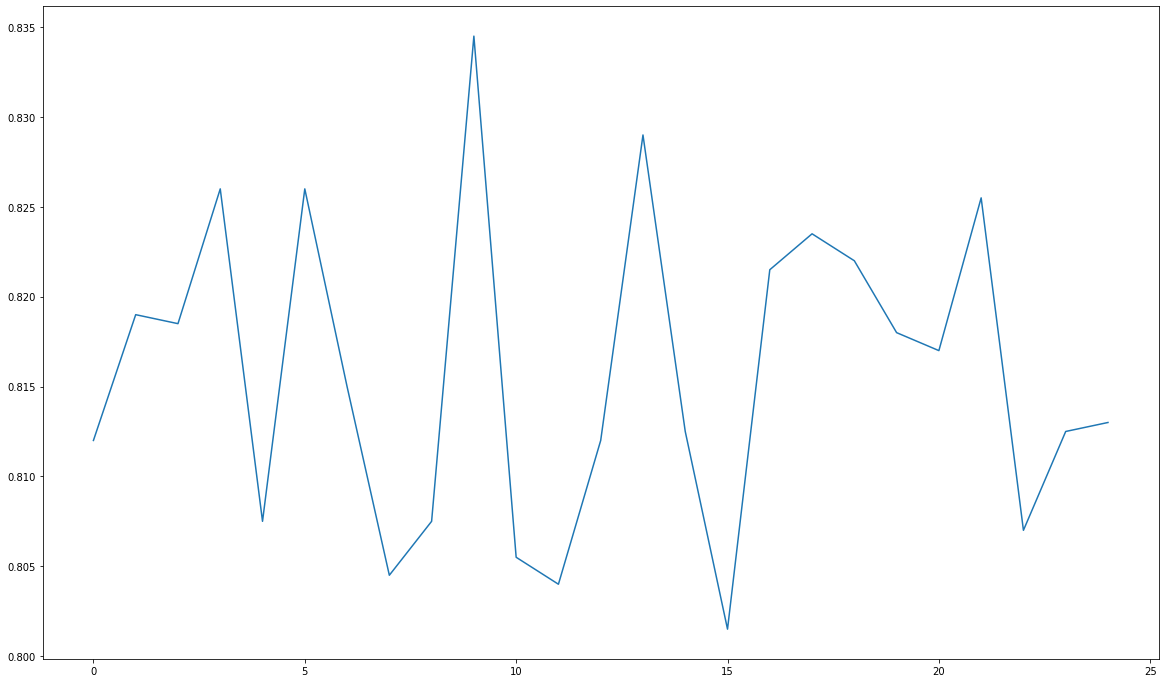

In [17]:
single_network_accuracies = []
networks = [create_network() for _ in range(num_trials)]
for model in networks:
    # Split the data into training and test
    nn_train_values, nn_test_values, nn_train_labels, nn_test_labels = train_test_split(NN_Data, NN_Labels, test_size=0.2)    
    nn_train_labels = keras.utils.to_categorical(nn_train_labels)
    nn_test_labels = keras.utils.to_categorical(nn_test_labels)
    train_network(model, nn_train_values, nn_train_labels)
    single_network_accuracies.append(evaluate_network(model, nn_test_values, nn_test_labels))
print('Average Accuracy for Network model: ', np.mean(single_network_accuracies)) 
plt.figure(figsize=(20,12))
plt.plot(single_network_accuracies)

In [18]:
example_model = create_network()
example_model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 30)                930       
_________________________________________________________________
dense_101 (Dense)            (None, 80)                2480      
_________________________________________________________________
dense_102 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_103 (Dense)            (None, 2)                 162       
Total params: 10,052
Trainable params: 10,052
Non-trainable params: 0
_________________________________________________________________


### Ensemble Neural Network

In [19]:
def ensemble_predictions(models, testX):
    # make predictions
    yhats = [model.predict(testX) for model in models]
    yhats = array(yhats)
    # sum across ensemble members
    summed = np.sum(yhats, axis=0)
    # argmax across classes
    result = np.argmax(summed, axis=1)
    return result

In [20]:
def evaluate_ensemble(models, num_models, testX, testy):
    # select a subset of members
    subset = models[:num_models]
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate accuracy
    return accuracy_score(testy, yhat)

Average Accuracy for Ensemble model:  0.8395822222222222


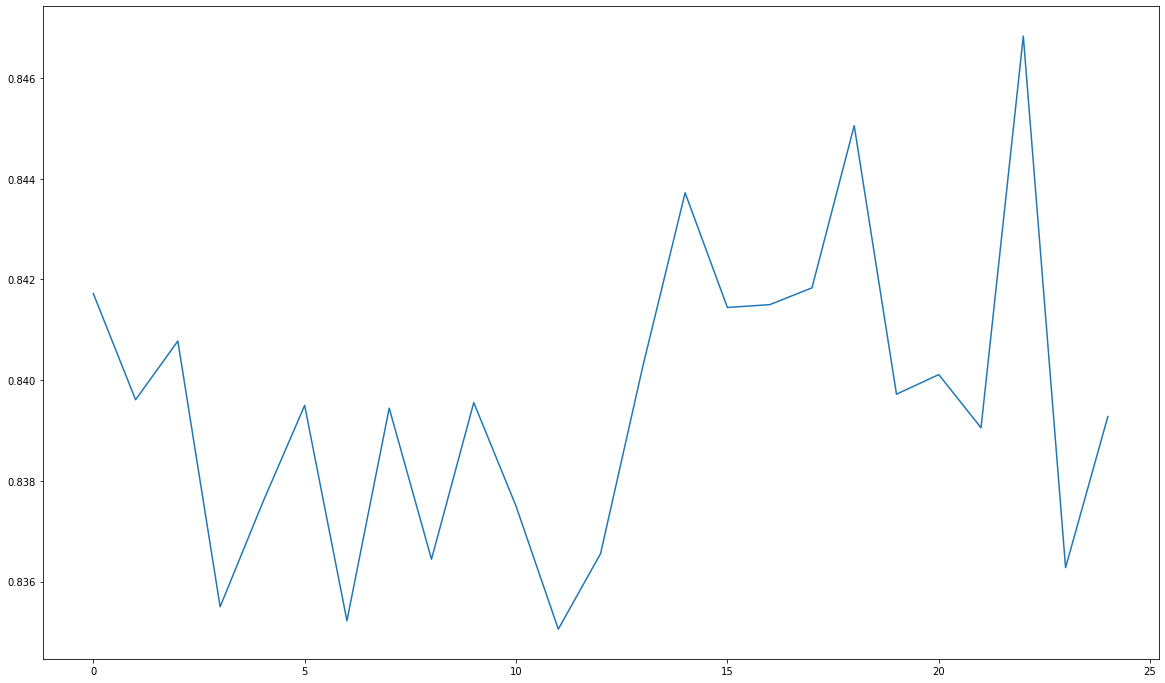

In [21]:
ensemble_accuracies = []
num_models = 10
for i in range(0,num_trials):
    networks = [create_network() for _ in range(num_models)]
    ensemble_scores = []
    for j in range(1, len(networks)):
        # Split the data into training and test
        nn_train_values, nn_test_values, nn_train_labels, nn_test_labels = train_test_split(NN_Data, NN_Labels, test_size=0.2)    
        nn_train_labels = keras.utils.to_categorical(nn_train_labels)
        # nn_test_labs = keras.utils.to_categorical(nn_test_labels)
        train_network(networks[j-1], nn_train_values, nn_train_labels)
        accuracy = evaluate_ensemble(networks, j, nn_test_values, nn_test_labels)
        ensemble_scores.append(accuracy)
    ensemble_accuracies.append(np.mean(ensemble_scores))
print('Average Accuracy for Ensemble model: ', np.mean(ensemble_accuracies))
plt.figure(figsize=(20,12))
plt.plot(ensemble_accuracies)

## Classical Approaches

### Supervised

#### K-Nearest Neigbours

In [22]:
# Create a copy of the data for this model
KNN_Data = atlas_processed
KNN_Labels = atlas_labels.to_numpy()

In [23]:
# Set the maximum number of neighbours to search across
search_max_val = 10
# Disable warnings
warnings.simplefilter('ignore')
# Create the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')
# Declare the grid for the GridSearch
grid = {"n_neighbors":range(1,search_max_val)}
# Perform the GridSearch on the model
knn_model_cv = GridSearchCV(knn_model, grid, cv=10)
knn_model_cv.fit(KNN_Data, KNN_Labels)
# Output the best Parameters
knn_model_cv.best_params_

{'n_neighbors': 8}

Average KNN Score over all trials:  0.7428125


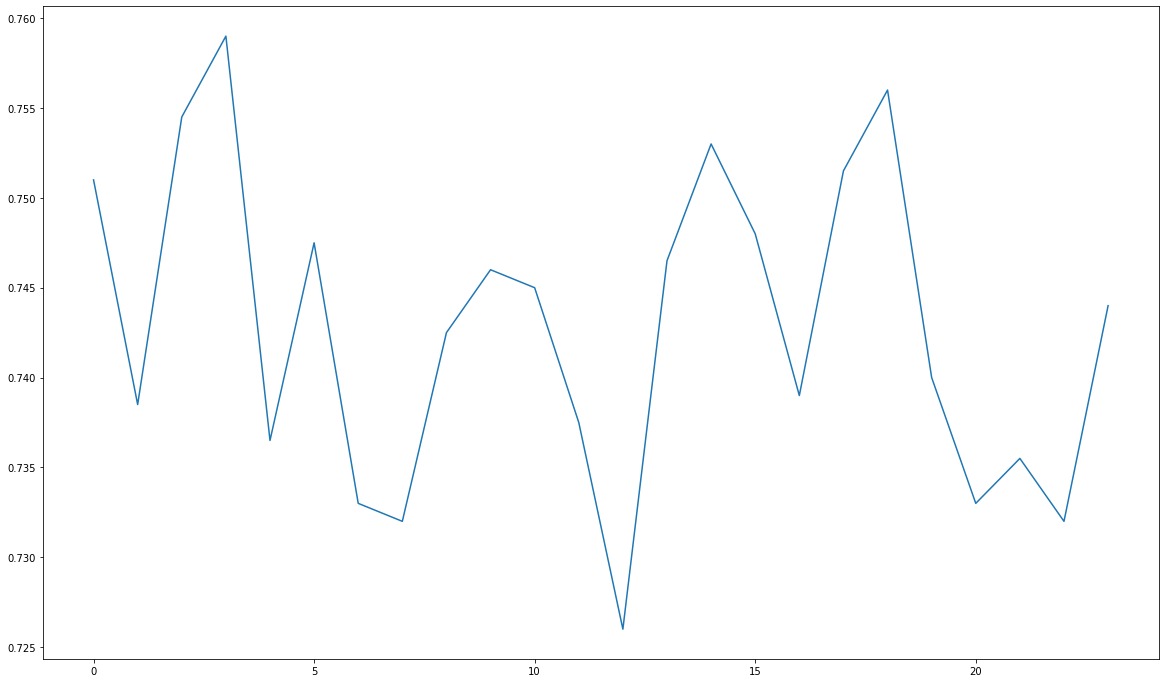

In [24]:
knn_accuracies =[]
for i in range(1, num_trials):
    knn_train_values, knn_test_values, knn_train_labels, knn_test_labels = train_test_split(KNN_Data, KNN_Labels, test_size=0.2)
    # Train the model using the best parameters and the train data
    knn_model_final = KNeighborsClassifier(n_neighbors=knn_model_cv.best_params_['n_neighbors'], algorithm='ball_tree')
    knn_model_final.fit(knn_train_values, knn_train_labels)
    knn_accuracies.append(knn_model_final.score(knn_test_values, knn_test_labels))
print('Average KNN Score over all trials: ',np.mean(knn_accuracies))
plt.figure(figsize=(20,12))
plt.plot(knn_accuracies)

#### Support Vector Machine - SVM

In [25]:
# Create a copy of the data
SVM_Data = atlas_processed
SVM_Labels = atlas_labels.to_numpy()

In [26]:
svm_train_values, svm_test_values, svm_train_labels,svm_test_labels = train_test_split(SVM_Data, SVM_Labels, test_size=0.2)
# Set the maximum amount of C values to search across
search_max_val = 10
# Declare the model with a linear kernel
svm_model_lin = SVC(kernel="linear")
# Set up the grid for the GridSearch
grid = {"C":range(1,search_max_val)}
# Perform the GridSearch
svm_model_cv = GridSearchCV(svm_model_lin, grid, cv=10)
svm_model_cv.fit(svm_train_values, svm_train_labels)
# Show optimal C
svm_model_cv.best_params_

{'C': 4}

Average Linear SVM score over all trials:  0.7322083333333333


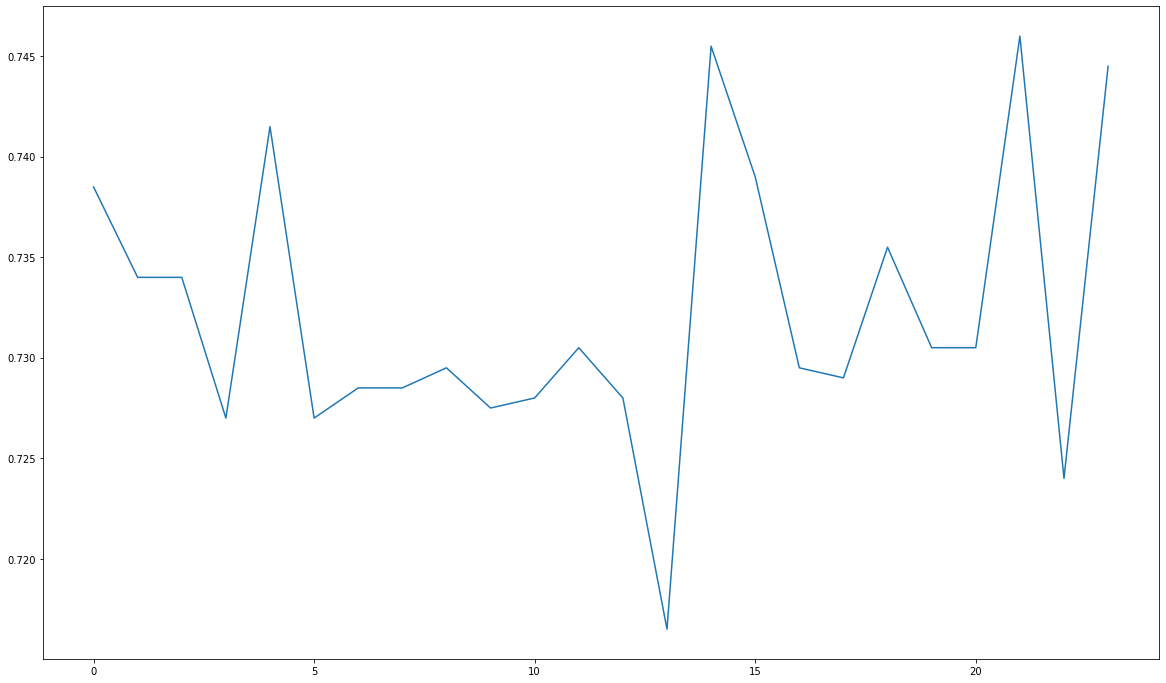

In [27]:
lin_accuracies = []
for i in range(1, num_trials):
    svm_train_values, svm_test_values, svm_train_labels,svm_test_labels = train_test_split(SVM_Data, SVM_Labels, test_size=0.2)
    # Create and train the model with optimal parameter
    svm_model_lin_final = SVC(C=svm_model_cv.best_params_['C'],kernel="linear")
    svm_model_lin_final.fit(svm_train_values, svm_train_labels)
    # Output the score using test data
    svm_lin_score = svm_model_lin_final.score(svm_test_values, svm_test_labels)
    lin_accuracies.append(svm_lin_score)
print('Average Linear SVM score over all trials: ',np.mean(lin_accuracies))
plt.figure(figsize=(20,12))
plt.plot(lin_accuracies)

RBF Variant

In [28]:
# Create an SVM with radial basis function kernel
svm_model_rbf = SVC(kernel="rbf")
# Set up the grid for the GridSearch
grid = {"C":range(1,search_max_val)}
# Perform the GridSearch
svm_model_cv = GridSearchCV(svm_model_rbf, grid, cv=10)
svm_model_cv.fit(svm_train_values, svm_train_labels)
# Output optimal C
svm_model_cv.best_params_

{'C': 3}

Average RBF SVM score over all trials:  0.8140624999999999


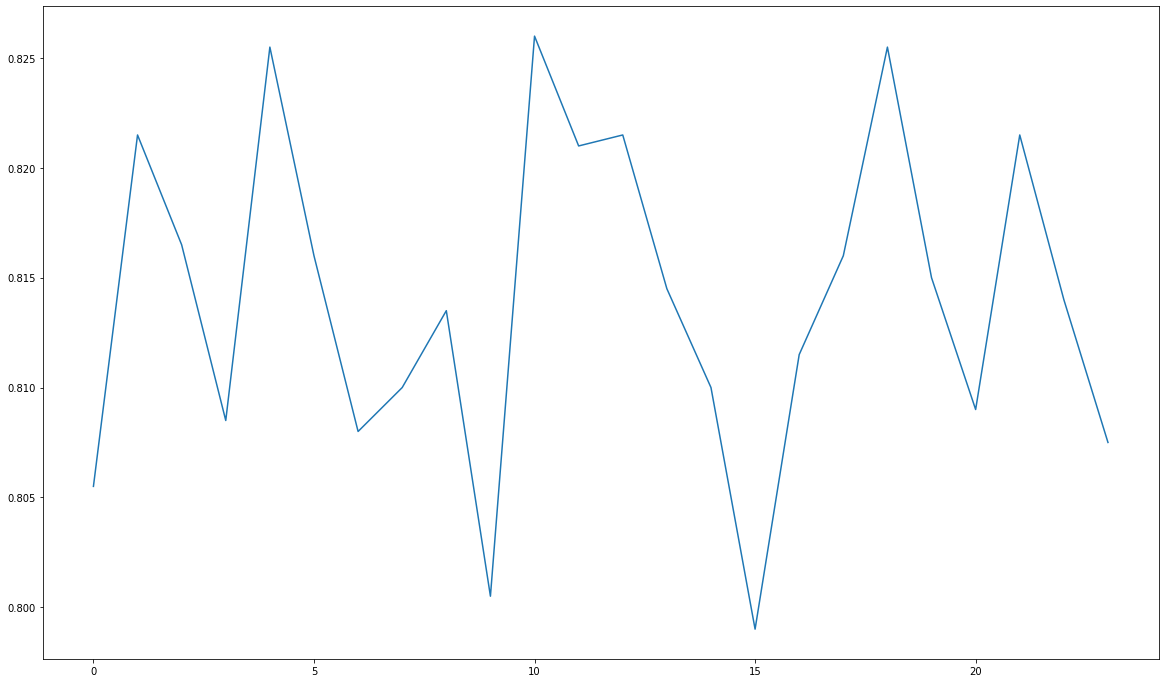

In [29]:
rbf_accuracies = []
for i in range(1, num_trials):
    svm_train_values, svm_test_values, svm_train_labels,svm_test_labels = train_test_split(SVM_Data, SVM_Labels, test_size=0.2)
    # Train model using optimal parameters
    svm_model_rbf_final = SVC(C=svm_model_cv.best_params_['C'],kernel="rbf")
    svm_model_rbf_final.fit(svm_train_values, svm_train_labels)
    # Output the score
    svm_rbf_score = svm_model_rbf_final.score(svm_test_values, svm_test_labels)
    rbf_accuracies.append(svm_rbf_score)
print('Average RBF SVM score over all trials: ',np.mean(rbf_accuracies))
plt.figure(figsize=(20,12))
plt.plot(rbf_accuracies)

### Unsupervised

#### K-Means Clustering

In [30]:
# Copy the data
KMEANS_Data = atlas_processed
KMEAN_Labels = atlas_labels.to_numpy()

In [31]:
# Declare values
iterations = 100

Average KMeans accuracy across trials:  0.49926000000000004


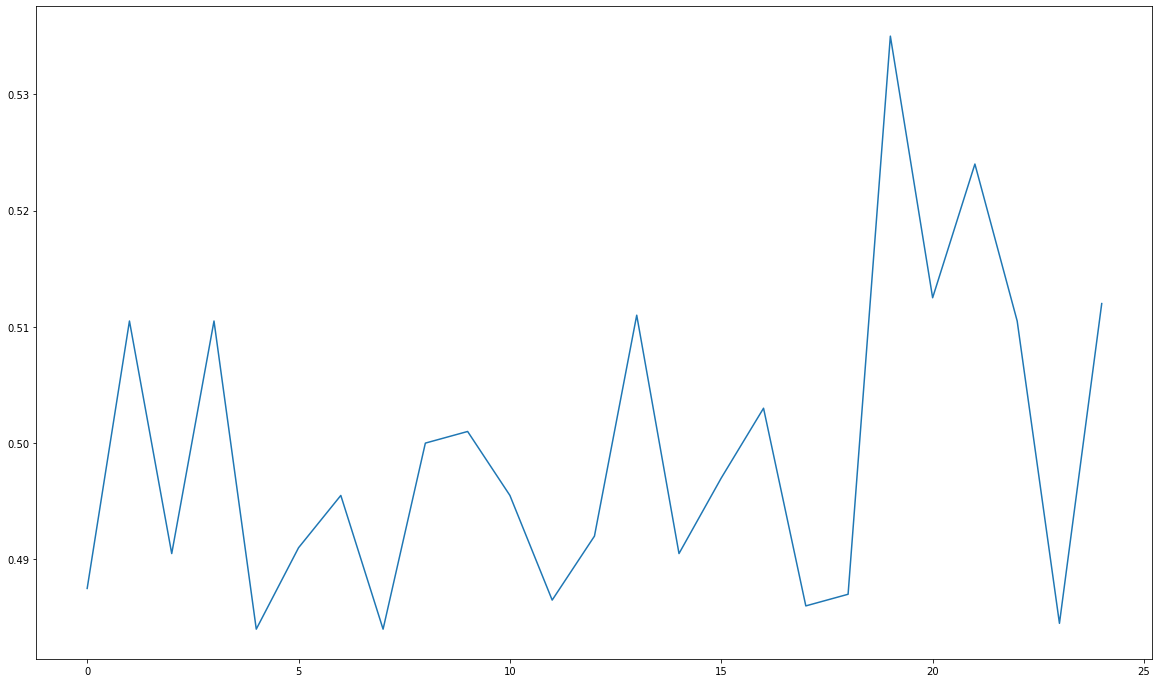

In [32]:
kmeans_accuracy = []
for i in range(0, num_trials):
    kmean_train_data, kmean_test_data, kmean_train_labels, kmean_test_labels = train_test_split(KMEANS_Data, KMEAN_Labels, test_size=0.2)
    # Create model using optimal parameters
    kmeans_model = KMeans(2, max_iter=iterations)
    kmeans_model.fit(kmean_train_data)
    results = kmeans_model.predict(kmean_test_data)
    counter = 0
    for i in range(0, len(kmean_test_labels)-1):
        if kmean_test_labels[i] == results[i]:
            counter += 1
    kmeans_accuracy.append(counter/len(kmean_test_labels))
print('Average KMeans accuracy across trials: ',np.mean(kmeans_accuracy))
plt.figure(figsize=(20,12))
plt.plot(kmeans_accuracy)

## Collation of Results

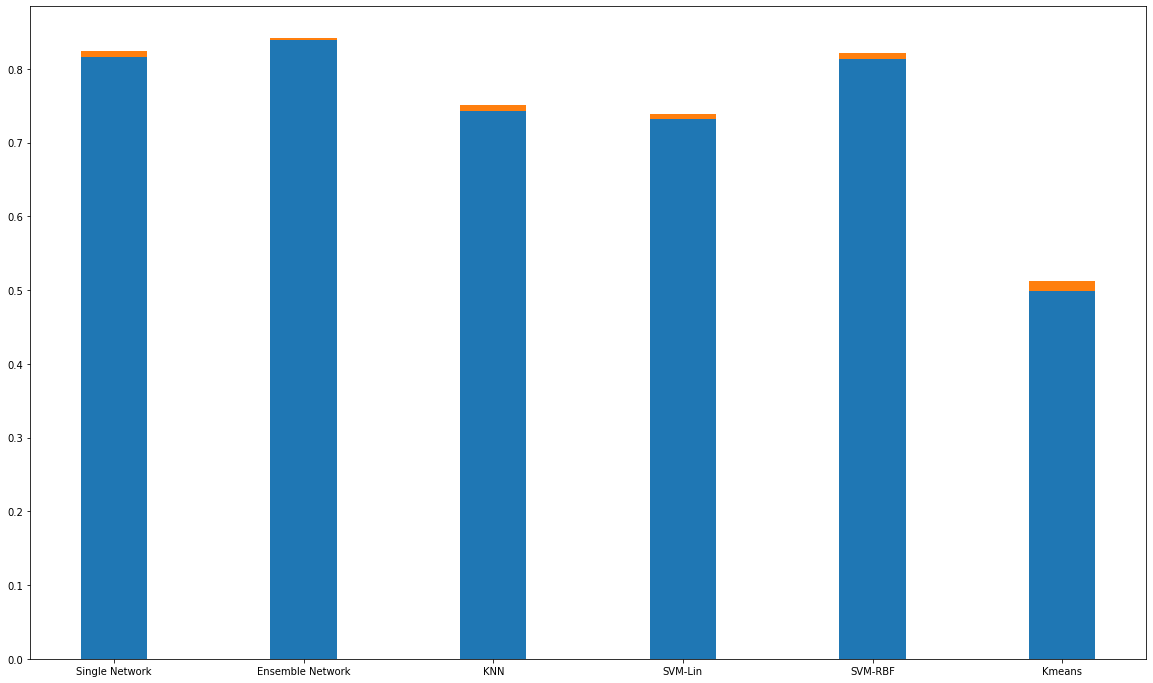

In [33]:
xlabels = ['Single Network','Ensemble Network','KNN', 'SVM-Lin', 'SVM-RBF', 'Kmeans']
collated_means = [np.mean(single_network_accuracies), np.mean(ensemble_accuracies), np.mean(knn_accuracies), np.mean(lin_accuracies), np.mean(rbf_accuracies), np.mean(kmeans_accuracy)]
collated_devs = [np.std(single_network_accuracies), np.std(ensemble_accuracies), np.std(knn_accuracies), np.std(lin_accuracies), np.std(rbf_accuracies), np.std(kmeans_accuracy)]
width = 0.35
plt.figure(figsize=(20,12))
p1 = plt.bar(xlabels,collated_means, width)
p2 = plt.bar(xlabels,collated_devs, width, bottom=collated_means)